In [0]:
from jax import jit, grad, vmap, random
from functools import partial
import jax
import jax.numpy as np
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, ConvTranspose, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid, BatchNorm # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
import matplotlib.pyplot as plt # visualization
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

mkdir: cannot create directory ‘data’: File exists
(32, 32, 3, 73257)


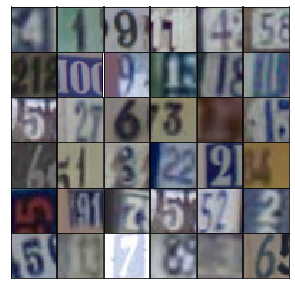

In [2]:
# Load data
!mkdir data
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
rng = random.PRNGKey(1)

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)
        
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

idx = random.randint(rng, shape=(36,), minval=0, maxval=trainset['X'].shape[3])
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)
print(trainset['X'].shape)

def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        # self.train_x = np.rollaxis(self.train_x, 3)
        # self.valid_x = np.rollaxis(self.valid_x, 3)
        # self.test_x = np.rollaxis(self.test_x, 3)
        self.train_x = np.transpose(self.train_x, (3,0,1,2))
        self.valid_x = np.transpose(self.valid_x, (3,0,1,2))
        self.test_x = np.transpose(self.test_x, (3,0,1,2))
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            random.shuffle(rng, idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

dataset = Dataset(trainset, testset)

In [0]:
#Setup environment and hyperparameters
g_out_dim = 3
d_out_dim = 1
z_size = 100
learning_rate = 0.0002
batch_size = 100
epochs = 25
beta1 = 0.5
alpha = 0.2

In [0]:
def Reshape(newshape):
  """Layer construction function for a reshape layer."""
  init_fun = lambda rng, input_shape: (newshape,())
  apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs,newshape)
  return init_fun, apply_fun

def MyLeakyRelu(alpha=0.01):
    """Layer construction function for a leaky relu layer with custom alpha."""
    init_fun = lambda rng, input_shape: (input_shape,())
    apply_fun = lambda params, inputs, **kwargs: np.where(inputs >= 0, inputs, alpha * inputs)
    return init_fun, apply_fun

In [5]:
#Define Generator
gen_init, gen_apply = stax.serial(
    Dense(4*4*512), Reshape((-1, 4, 4, 512)), BatchNorm(axis=(0,)), MyLeakyRelu(alpha),
    ConvTranspose(256, (5,5), strides=(2,2), padding='SAME'), BatchNorm(axis=(0,)), MyLeakyRelu(alpha),
    ConvTranspose(128, (5,5), strides=(2,2), padding='SAME'), BatchNorm(axis=(0,)), MyLeakyRelu(alpha),
    ConvTranspose(g_out_dim, (5,5), strides=(2,2), padding='SAME'), BatchNorm(axis=(0,)), Tanh
)
g_in_shape = (-1, z_size)
_, gen_params = gen_init(rng, g_in_shape)
input_z = random.uniform(rng, shape=(batch_size, z_size), minval=-1., maxval=1.)
g_out=gen_apply(gen_params, input_z)
print(g_out.shape)

(100, 32, 32, 3)


In [6]:
#Define Discriminator
disc_init, disc_apply = stax.serial(
    Conv(64, (5,5), strides=(2,2), padding='SAME'), MyLeakyRelu(alpha),
    Conv(128, (5,5), strides=(2,2), padding='SAME'), BatchNorm(axis=(0,)), MyLeakyRelu(alpha),
    Conv(256, (5,5), strides=(2,2), padding='SAME'), BatchNorm(axis=(0,)), MyLeakyRelu(alpha),
    Flatten,
    Dense(d_out_dim)    
)
d_in_shape = (-1, 32, 32, g_out_dim)
_, disc_params = disc_init(rng, d_in_shape)
input_real, y = [(x,y) for x,y in dataset.batches(batch_size)][0]
d_out = disc_apply(disc_params, input_real)
print(input_real.shape, d_out.shape)

(100, 32, 32, 3) (100, 1)


In [0]:
#Define Losses and Optimizers
def cross_entropy_with_logits(targets, logits):
    predictions = sigmoid(logits)
    return -(targets*np.log(predictions+1e-9)+(1-targets)*np.log(1-predictions+1e-9))

def loss(gen_params, disc_params, input_z, input_real):
    g_out = gen_apply(gen_params, input_z)
    d_logits_real = disc_apply(disc_params, input_real)
    d_logits_fake = disc_apply(disc_params, g_out)
    d_loss_real = np.mean(cross_entropy_with_logits(targets=np.ones_like(d_logits_real), logits=d_logits_real))
    d_loss_fake = np.mean(cross_entropy_with_logits(targets=np.zeros_like(d_logits_fake), logits=d_logits_fake))
    d_loss = d_loss_real + d_loss_fake
    g_loss = np.mean(cross_entropy_with_logits(targets=np.ones_like(d_logits_fake), logits=d_logits_fake))
    return g_loss, d_loss

g_opt_init, g_opt_update, g_get_params = optimizers.adam(step_size=learning_rate, b1=beta1)
d_opt_init, d_opt_update, d_get_params = optimizers.adam(step_size=learning_rate, b1=beta1)
g_opt_state = g_opt_init(gen_params)
d_opt_state = d_opt_init(disc_params)

@jit
def step(i, g_opt_state, d_opt_state, input_z, input_real):
    g_params = g_get_params(g_opt_state)
    d_params = d_get_params(d_opt_state)
    g_loss = lambda x: loss(x, d_params, input_z, input_real)[0]
    d_loss = lambda y: loss(g_params, y, input_z, input_real)[1]
    gen_grad = grad(g_loss)(g_params)
    disc_grad = grad(d_loss)(d_params)
    gl, dl = loss(g_params, d_params, input_z, input_real)
    return g_opt_update(i, gen_grad, g_opt_state), d_opt_update(i, disc_grad, d_opt_state), gl, dl

In [8]:
print(input_z.shape, input_real.shape, loss(gen_params, disc_params, input_z, input_real))
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

(100, 100) (100, 32, 32, 3) (DeviceArray(0.570372, dtype=float32), DeviceArray(1.6008396, dtype=float32))


Epoch 1/25... Discriminator Loss: 2.7110... Generator Loss: 0.2737
Epoch 1/25... Discriminator Loss: 2.6932... Generator Loss: 0.3072
Epoch 1/25... Discriminator Loss: 2.7489... Generator Loss: 0.4296
Epoch 1/25... Discriminator Loss: 2.3914... Generator Loss: 0.5278
Epoch 1/25... Discriminator Loss: 2.1526... Generator Loss: 0.4173
Epoch 1/25... Discriminator Loss: 2.2151... Generator Loss: 0.3936
Epoch 1/25... Discriminator Loss: 1.8136... Generator Loss: 0.4738
Epoch 1/25... Discriminator Loss: 1.9908... Generator Loss: 0.6017
Epoch 1/25... Discriminator Loss: 1.9137... Generator Loss: 0.5265
Epoch 1/25... Discriminator Loss: 1.8555... Generator Loss: 0.6063


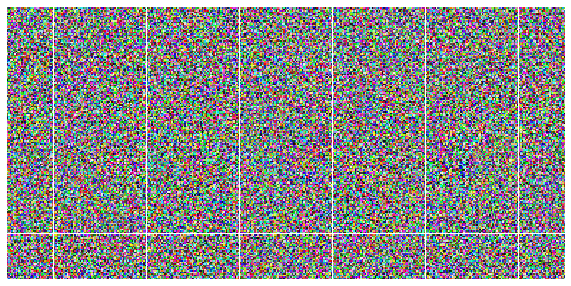

Epoch 1/25... Discriminator Loss: 1.6166... Generator Loss: 0.6512
Epoch 1/25... Discriminator Loss: 1.8928... Generator Loss: 0.5359
Epoch 1/25... Discriminator Loss: 1.7340... Generator Loss: 0.6024
Epoch 1/25... Discriminator Loss: 1.3211... Generator Loss: 0.7550
Epoch 1/25... Discriminator Loss: 1.4738... Generator Loss: 0.8352
Epoch 1/25... Discriminator Loss: 1.6802... Generator Loss: 0.9230
Epoch 1/25... Discriminator Loss: 1.2569... Generator Loss: 1.0067
Epoch 1/25... Discriminator Loss: 1.1106... Generator Loss: 0.7893
Epoch 1/25... Discriminator Loss: 1.4678... Generator Loss: 0.6676
Epoch 1/25... Discriminator Loss: 1.2239... Generator Loss: 0.8506


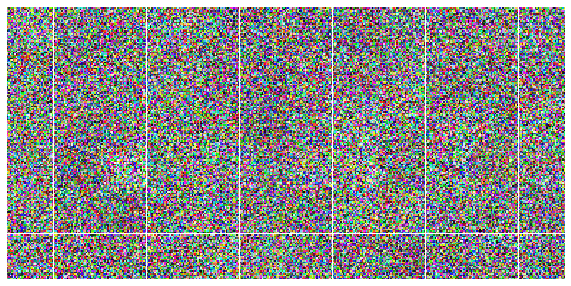

Epoch 1/25... Discriminator Loss: 1.2459... Generator Loss: 0.8005
Epoch 1/25... Discriminator Loss: 1.2748... Generator Loss: 0.8406
Epoch 1/25... Discriminator Loss: 1.3224... Generator Loss: 0.9772
Epoch 1/25... Discriminator Loss: 0.9594... Generator Loss: 0.9712
Epoch 1/25... Discriminator Loss: 1.0520... Generator Loss: 1.1112
Epoch 1/25... Discriminator Loss: 0.9763... Generator Loss: 1.0269
Epoch 1/25... Discriminator Loss: 0.9219... Generator Loss: 0.9206
Epoch 1/25... Discriminator Loss: 0.6699... Generator Loss: 1.2950
Epoch 1/25... Discriminator Loss: 1.5732... Generator Loss: 1.1212
Epoch 1/25... Discriminator Loss: 1.1558... Generator Loss: 1.1532


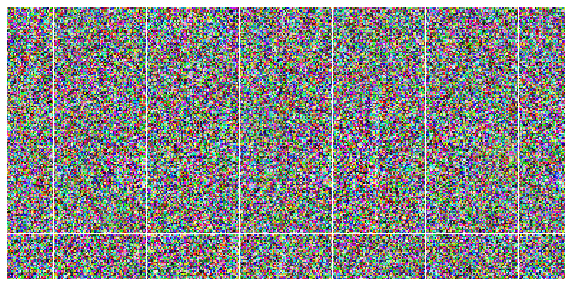

Epoch 1/25... Discriminator Loss: 0.8841... Generator Loss: 1.2079
Epoch 1/25... Discriminator Loss: 0.8410... Generator Loss: 1.2724
Epoch 1/25... Discriminator Loss: 1.0039... Generator Loss: 1.3027
Epoch 1/25... Discriminator Loss: 1.1675... Generator Loss: 1.1155
Epoch 1/25... Discriminator Loss: 1.4115... Generator Loss: 1.2371
Epoch 1/25... Discriminator Loss: 0.7491... Generator Loss: 1.1304
Epoch 1/25... Discriminator Loss: 0.9300... Generator Loss: 0.9140
Epoch 1/25... Discriminator Loss: 1.1514... Generator Loss: 1.0464
Epoch 1/25... Discriminator Loss: 1.0136... Generator Loss: 0.8310
Epoch 1/25... Discriminator Loss: 1.3208... Generator Loss: 0.8014


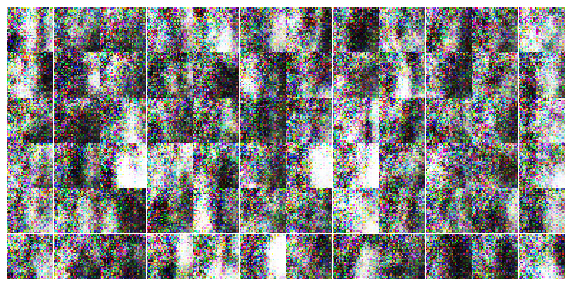

Epoch 1/25... Discriminator Loss: 1.2499... Generator Loss: 0.7480
Epoch 1/25... Discriminator Loss: 1.5709... Generator Loss: 0.8848
Epoch 1/25... Discriminator Loss: 1.6360... Generator Loss: 0.8361
Epoch 1/25... Discriminator Loss: 1.4079... Generator Loss: 0.8869
Epoch 1/25... Discriminator Loss: 1.6812... Generator Loss: 0.6423
Epoch 1/25... Discriminator Loss: 1.6759... Generator Loss: 0.9708
Epoch 1/25... Discriminator Loss: 1.2794... Generator Loss: 0.7294
Epoch 1/25... Discriminator Loss: 1.4718... Generator Loss: 0.7388
Epoch 1/25... Discriminator Loss: 1.3233... Generator Loss: 0.6474
Epoch 1/25... Discriminator Loss: 1.4196... Generator Loss: 0.6476


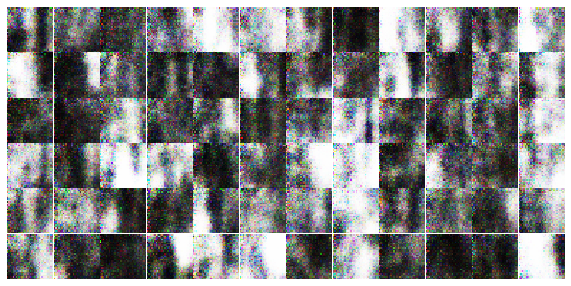

Epoch 1/25... Discriminator Loss: 1.6501... Generator Loss: 0.8881
Epoch 1/25... Discriminator Loss: 1.3367... Generator Loss: 0.7435
Epoch 1/25... Discriminator Loss: 1.2672... Generator Loss: 0.6758
Epoch 1/25... Discriminator Loss: 1.3151... Generator Loss: 0.8733
Epoch 1/25... Discriminator Loss: 1.3803... Generator Loss: 0.7252
Epoch 1/25... Discriminator Loss: 1.6006... Generator Loss: 0.8297
Epoch 1/25... Discriminator Loss: 1.2105... Generator Loss: 0.7137
Epoch 1/25... Discriminator Loss: 1.4841... Generator Loss: 0.6978
Epoch 1/25... Discriminator Loss: 1.2761... Generator Loss: 0.6630
Epoch 1/25... Discriminator Loss: 1.3088... Generator Loss: 0.5863


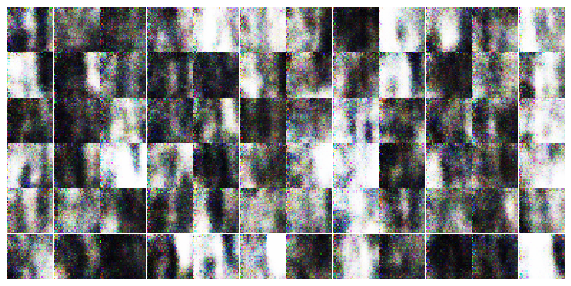

Epoch 1/25... Discriminator Loss: 1.4144... Generator Loss: 0.7443
Epoch 1/25... Discriminator Loss: 1.3268... Generator Loss: 0.7508
Epoch 1/25... Discriminator Loss: 1.4525... Generator Loss: 0.9547
Epoch 1/25... Discriminator Loss: 1.4424... Generator Loss: 0.8868
Epoch 1/25... Discriminator Loss: 1.3159... Generator Loss: 0.7311
Epoch 1/25... Discriminator Loss: 1.2678... Generator Loss: 1.0095
Epoch 1/25... Discriminator Loss: 1.2062... Generator Loss: 0.9334
Epoch 1/25... Discriminator Loss: 1.2530... Generator Loss: 1.0136
Epoch 1/25... Discriminator Loss: 1.3031... Generator Loss: 0.6786
Epoch 1/25... Discriminator Loss: 1.3004... Generator Loss: 0.6746


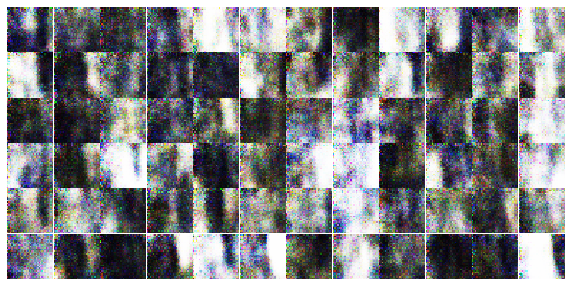

Epoch 1/25... Discriminator Loss: 1.1652... Generator Loss: 0.8516
Epoch 1/25... Discriminator Loss: 1.2285... Generator Loss: 0.7156
Epoch 1/25... Discriminator Loss: 1.2958... Generator Loss: 0.5678
Epoch 2/25... Discriminator Loss: 1.2874... Generator Loss: 0.5890
Epoch 2/25... Discriminator Loss: 1.4190... Generator Loss: 0.5925
Epoch 2/25... Discriminator Loss: 1.2326... Generator Loss: 0.6524
Epoch 2/25... Discriminator Loss: 1.3811... Generator Loss: 1.0800
Epoch 2/25... Discriminator Loss: 1.1753... Generator Loss: 0.7676
Epoch 2/25... Discriminator Loss: 1.4969... Generator Loss: 0.7127
Epoch 2/25... Discriminator Loss: 1.1090... Generator Loss: 0.7729


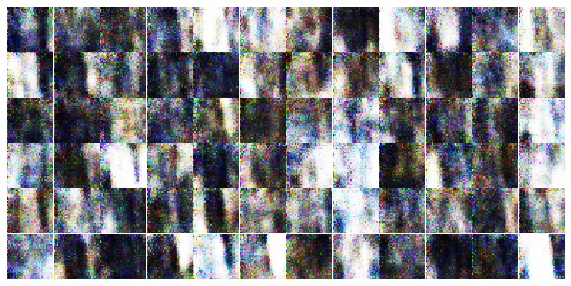

Epoch 2/25... Discriminator Loss: 1.3971... Generator Loss: 0.6206
Epoch 2/25... Discriminator Loss: 1.1545... Generator Loss: 0.9327
Epoch 2/25... Discriminator Loss: 1.2991... Generator Loss: 0.8645
Epoch 2/25... Discriminator Loss: 1.4750... Generator Loss: 0.6603
Epoch 2/25... Discriminator Loss: 1.3088... Generator Loss: 0.8882
Epoch 2/25... Discriminator Loss: 1.1141... Generator Loss: 1.3267
Epoch 2/25... Discriminator Loss: 1.6360... Generator Loss: 1.0601
Epoch 2/25... Discriminator Loss: 1.2989... Generator Loss: 0.6368
Epoch 2/25... Discriminator Loss: 1.3075... Generator Loss: 0.9114
Epoch 2/25... Discriminator Loss: 1.3713... Generator Loss: 0.6937


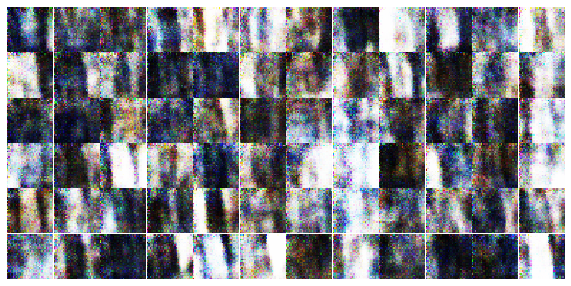

Epoch 2/25... Discriminator Loss: 1.3105... Generator Loss: 1.1395
Epoch 2/25... Discriminator Loss: 1.3433... Generator Loss: 0.8646
Epoch 2/25... Discriminator Loss: 1.3452... Generator Loss: 1.0987
Epoch 2/25... Discriminator Loss: 1.7396... Generator Loss: 1.2329
Epoch 2/25... Discriminator Loss: 1.2001... Generator Loss: 0.6416
Epoch 2/25... Discriminator Loss: 1.3154... Generator Loss: 0.7634
Epoch 2/25... Discriminator Loss: 1.5380... Generator Loss: 0.9169
Epoch 2/25... Discriminator Loss: 1.2381... Generator Loss: 0.6708
Epoch 2/25... Discriminator Loss: 1.0849... Generator Loss: 0.9125
Epoch 2/25... Discriminator Loss: 1.0749... Generator Loss: 0.7954


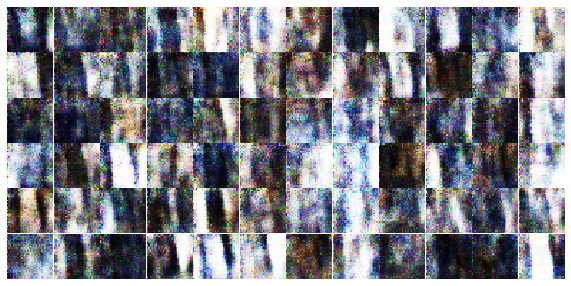

Epoch 2/25... Discriminator Loss: 1.1904... Generator Loss: 0.6768
Epoch 2/25... Discriminator Loss: 1.0804... Generator Loss: 0.8239
Epoch 2/25... Discriminator Loss: 1.3244... Generator Loss: 0.7634
Epoch 2/25... Discriminator Loss: 1.1934... Generator Loss: 0.5696
Epoch 2/25... Discriminator Loss: 1.3893... Generator Loss: 0.7914
Epoch 2/25... Discriminator Loss: 1.3044... Generator Loss: 1.0112
Epoch 2/25... Discriminator Loss: 1.3069... Generator Loss: 0.6543
Epoch 2/25... Discriminator Loss: 1.1904... Generator Loss: 0.7351
Epoch 2/25... Discriminator Loss: 1.4108... Generator Loss: 0.7275
Epoch 2/25... Discriminator Loss: 1.4291... Generator Loss: 0.5208


In [0]:
#Training
sample_z = random.uniform(rng, shape=(72, z_size), minval=-1., maxval=1.)

samples, losses = [], []
steps = 0

for e in range(epochs):
    for x, y in dataset.batches(batch_size):
        steps += 1

        # Sample random noise for G
        batch_z = random.uniform(rng, shape=(batch_size, z_size), minval=-1., maxval=1.)

        #Take steps
        g_opt_state, d_opt_state, gl, dl = step(steps-1, g_opt_state, d_opt_state, batch_z, x)
        #print(dl,gl)

        if steps % 10 == 0:
            print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(dl),
                          "Generator Loss: {:.4f}".format(gl))
                    # Save losses to view after training
            losses.append((dl, gl))

        if steps % 100 == 0:
            gen_params = g_get_params(g_opt_state)
            gen_samples = gen_apply(gen_params, sample_z)
            samples.append(gen_samples)
            _ = view_samples(-1, samples, 6, 12, figsize=(10,5))
            plt.show()